# Predicting severity of heart disease through data analysis

Group 10: Samantha Lam, Sohayl Allibhai, Amanda Yang, Bolun Xie



## Introduction:

Though treatment has advanced, the prevalence of heart disease has risen in lower-income communities, contributing to cardiovascular disease being a leading cause of premature death (Bowry et al. 2015). This trend is reflected in Canada with cardiovascular disease disproportionately increasing in lower-income areas despite the overall decline of heart disease in the general population (Dai et al. 2021). There is therefore demand for more efficient methods of diagnosing heart disease and we aim to ascertain the severity of heart disease for unique individuals by analyzing a list of attributes taken from a dataset from the Cleveland Clinic Foundation (Detrano et al. 1989). 

As such, we want to see if we are able to use the variables **age (years)**, **resting blood pressure in mmHg (restbps)** , and **serum cholestoral in mg/dL (chol)** to classify the severity of a unique individuals heart disease **(num)** with accurately using a K-nearest neighbour classification model. This model was chosen primarily because it requires very few assumptions about the data, which we did not have much information about. 

The predictor variables were chosen from the processed Cleveland data set both due to the strong correlation each had with the severity of heart disease (Detrano et al. 1989) and because they were quantifiable as the K-nearest neighbours classification model works best with quantifiable predictor variables. 

David W. Aha refined the raw dataset to create the processed dataset that we will utilize. (UCI Machine Learning Repository: Heart Disease Data Set). 

## Method

Start by running the cell below to load the libraries needed for data analysis 

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
#install.packages("themis")
#library(themis)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### Preliminary Exploration

Download the dataset and read it into a dataframe.

In [2]:
my_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
download.file(my_url, "cleveland.csv")
cleveland_sel <- read_csv("cleveland.csv", col_names = FALSE)
cleveland_sel <- rename(cleveland_sel, "age" = X1,
                     "sex" = X2,
                     "cp" = X3,
                     "restbps" = X4,
                     "chol" = X5,
                     "fbs" = X6,
                     "restecg" = X7,
                     "thalach" = X8,
                     "exnag" = X9,
                     "oldpeak" = X10,
                     "slope" = X11,
                     "ca" = X12,
                     "thal" = X13,
                     "num" = X14)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



Here we select for our chosen predictor variables, **age**, **restbps** (resting blood pressure), **chol** (serum cholestoral in mg/dl) and target variable **num** (diagnosis of heart disease and severity) that we want to use to build our model


In [3]:
cleveland_df_sel<-select(cleveland_sel,age, restbps, chol, num)
cleveland_df_sel

age,restbps,chol,num
<dbl>,<dbl>,<dbl>,<dbl>
63,145,233,0
67,160,286,2
67,120,229,1
⋮,⋮,⋮,⋮
57,130,131,3
57,130,236,1
38,138,175,0


Convert the **num** numerical variable into a factor, as this is what we wish to predict using our model. 

In [4]:
cleveland_df_sel <- cleveland_df_sel %>% mutate(num=as_factor(num))
cleveland_df_sel

age,restbps,chol,num
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,0
67,160,286,2
67,120,229,1
⋮,⋮,⋮,⋮
57,130,131,3
57,130,236,1
38,138,175,0


As there as different classes of severity of heart disease, with **0** being no heart disease and **4** being severe heart disease (Nahar et al., 2013), we want to find the percentage of the different classes of severity of heart disease to better understand the distribution. 

In [54]:
num_obs <- nrow(cleveland_df_sel) 
cleveland_df_sel %>% 
    group_by(num) %>% 
    summarize(
        count = n(), 
        percentage = n() / num_obs * 100) 

`summarise()` ungrouping output (override with `.groups` argument)



num,count,percentage
<fct>,<int>,<dbl>
0,164,54.125413
1,55,18.151815
2,36,11.881188
3,35,11.551155
4,13,4.290429


We then explore the data by creating visual representations of the variables relationships to one another. We will explore the relationships as such 

1. Age and resting blood pressure
2. Age and serum cholestoral
3. Resting blood pressure and serum cholerstoral


#### Relationship between age and resting blood pressure 

There is a strong correlation between **age and resting blood pressure** (Roth et al. 2020), and we would therefore like to explore this relationship in our data set. Diagnosis refers to the severity of heart disease diagnosed with 0 being no heart disease and 4 being severe heart disease.

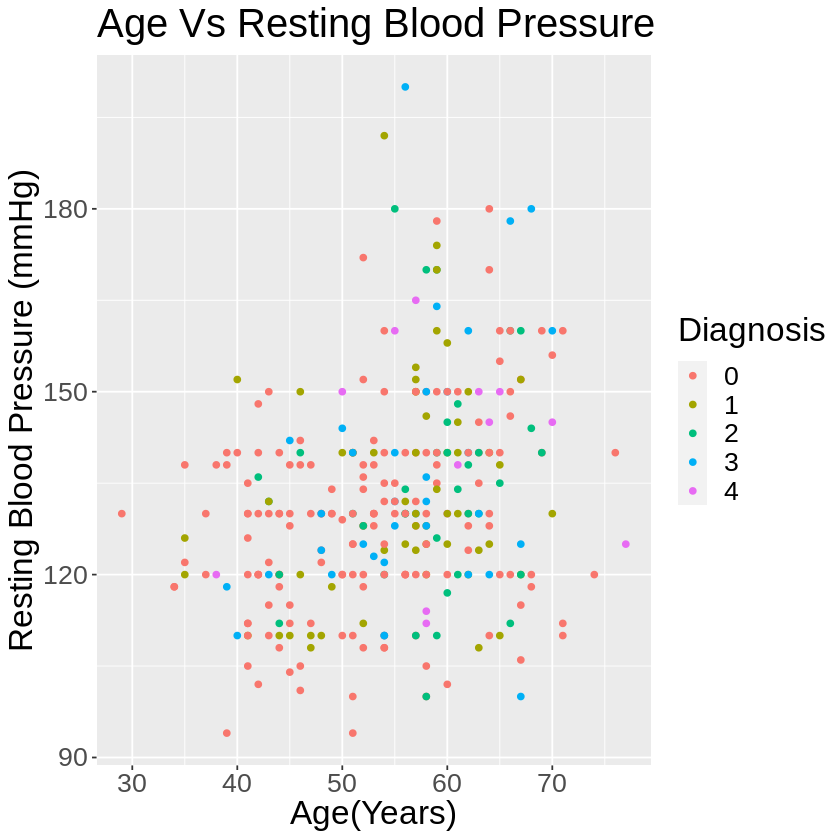

In [55]:
age_restbps <- cleveland_df_sel %>% 
    ggplot(aes(x=age,y=restbps, color = num)) +
    geom_point() + 
    labs(x="Age(Years)", y="Resting Blood Pressure (mmHg)", color = "Diagnosis")+
    theme(text = element_text(size = 20))+ 
    ggtitle("Age Vs Resting Blood Pressure")

age_restbps

From this we can see that _____ 

#### Relationship between age and serum cholestoral

There is also a strong correlation between **age and serum cholestoral** (Libby and Theroux 2005), and we would therefore like to explore this relationship in our data set. Diagnosis refers to the severity of heart disease diagnosed with 0 being no heart disease and 4 being severe heart disease.


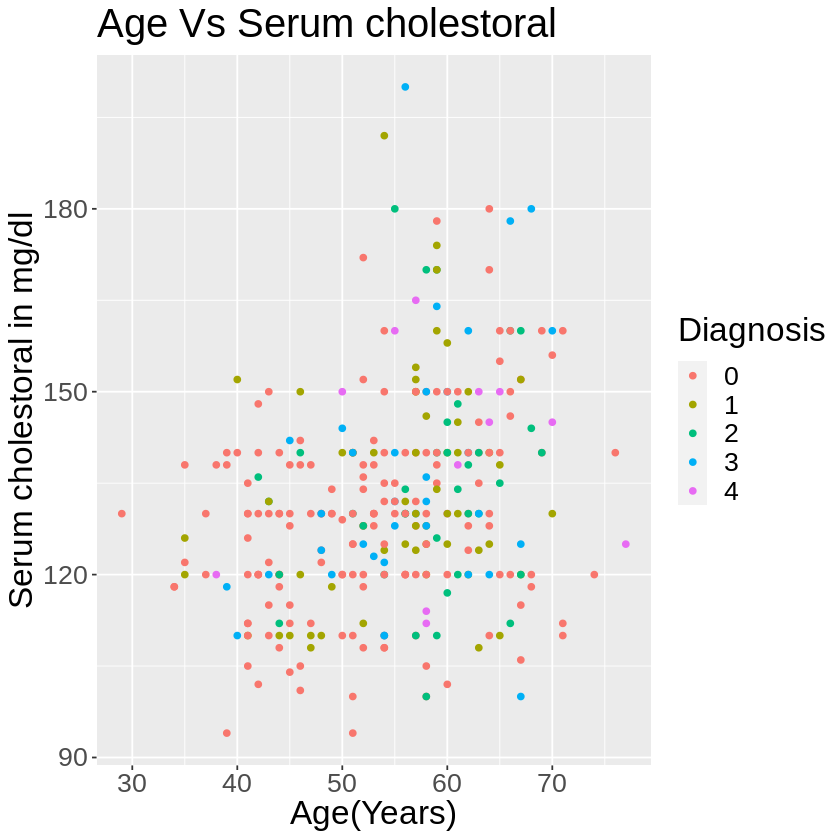

In [56]:
age_chol <- cleveland_df_sel %>% 
    ggplot(aes(x=age,y=restbps, color = num)) +
    geom_point() + 
    labs(x="Age(Years)", y="Serum cholestoral in mg/dl", color = "Diagnosis")+
    theme(text = element_text(size = 20))+ 
    ggtitle("Age Vs Serum cholestoral")

age_chol

#### Relationship between resting blood pressure and serum cholestoral

There is also a strong correlation between **resting blood pressure and serum cholestoral**  (Mannien et al. 1992), and we would therefore like to explore this relationship in our data set. Diagnosis refers to the severity of heart disease diagnosed with 0 being no heart disease and 4 being severe heart disease.


In [ ]:
age_num <- cleveland_df_sel %>% 
    ggplot(aes(x=restbps,y=chol, color = num)) +
    geom_point() + 
    labs(x="Resting Blood Pressure (mmHg)", y="Serum cholestoral in mg/dl", color = "Diagnosis")+
    theme(text = element_text(size = 20))+ 
    ggtitle("Resting Blood Pressure Vs Serum cholestoral")

age_num

With this, we have finished exploring the data with visualisations. We have established that there are correlations between age, serum cholesterol (chol) and resting blood pressure (trestbps). _(add other reasons to do with num)_ From this, we can be more confident that we can use these three variables to predict the severity of heart disease (num). 

### Building the K-nearest neighbors classification model 

Run this to set the seed **(This is not optional as we want to be able to reproduce this data)** and split the data into training and testing sets in a 70:30 ratio. We used a 70/30 split here because we found this made our training set large enough to train our model as accurately as possible whilst still having our test set large enough to assess the accuracy of our model. 

In [6]:
set.seed(888)

patients_split<-initial_split(cleveland_df_sel, prop = 0.70, strata = num) 
patients_train<- training(patients_split)
patients_test<- testing(patients_split)

patients_test
patients_train



age,restbps,chol,num
<dbl>,<dbl>,<dbl>,<fct>
53,140,203,1
57,140,192,0
56,140,294,0
⋮,⋮,⋮,⋮
39,138,220,0
58,130,197,0
59,164,176,3


age,restbps,chol,num
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,0
67,160,286,2
67,120,229,1
⋮,⋮,⋮,⋮
57,130,131,3
57,130,236,1
38,138,175,0


In [7]:
disease_prop <- patients_train %>%
    group_by(num) %>%
    summarize(n=n()) %>%
    mutate(percent = 100*n/nrow(patients_train))

disease_prop

`summarise()` ungrouping output (override with `.groups` argument)



num,n,percent
<fct>,<int>,<dbl>
0,114,53.271028
1,40,18.691589
2,27,12.616822
3,26,12.149533
4,7,3.271028


Referencing this data to the original proportions of the dataset, confirms that the proportions were preserved during the split. This is good as it means that the training set is comparable to the original dataset. 

_We have copied the code cell for the proportions of the original dataset below for easy comparison_ 

In [63]:
num_obs <- nrow(cleveland_df_sel) 
cleveland_df_sel %>% 
    group_by(num) %>% 
    summarize(
        count = n(), 
        percentage = n() / num_obs * 100) 

`summarise()` ungrouping output (override with `.groups` argument)



num,count,percentage
<fct>,<int>,<dbl>
0,164,54.125413
1,55,18.151815
2,36,11.881188
3,35,11.551155
4,13,4.290429


### Pre-Process Data

As we have three predictors that we can use to predict heart disease severity, we want to find the best subset of predictors to build our classifier model. To do so, we will have to build four verisons of our classifier 

1. Classifer with all three predictors (age, restbps, chol) 
2. Classifier with only chol and age 
3. Classifier with only chol and restbps
4. Classifier with only age and restbps 

Futhermore, as we are using a K-nearest neighbours classifier, we have a parameter K. In order to build the most accurate classifer, we want to choose the best K. To do so, we want to both cross-validate and tune our model. 

To split up our training data for cross-validation, we will create the object **heart_vfold**. 

Similarily, to tune our model and create our model specification, we will create the object **knn_tune**. 

To assess the accuracy of our model, we will have to fit the model for each value for all our K values, as such we will have to create a data frame **k_vals** that contain all the values of K to try. 

We explain this here to show that **heart_vfold, knn_tune** and **k_vals** will all be identifical in all four versions of our classifer model as they do not depend on the chosen variables. Therefore, we will write and run the code for all three below **before** building our classifers for conciseness and readability. 

In [8]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

In [9]:
heart_vfold <- vfold_cv(patients_train, v=5, strata = num)

#we specified 5 folds instead of 10 for our cross validation as it resulted
#in a higher accuracy

In [10]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

We will now begin to build the 4 version of our classifiers

#### _Scenario 1: using all 3 predictors_

We first build our classifier before tuning it and determing the best value of K by plotting a graph of accuracy vs K. 

! Fold2: internal: No observations were detected in `truth` for level(s): '4'
Com...



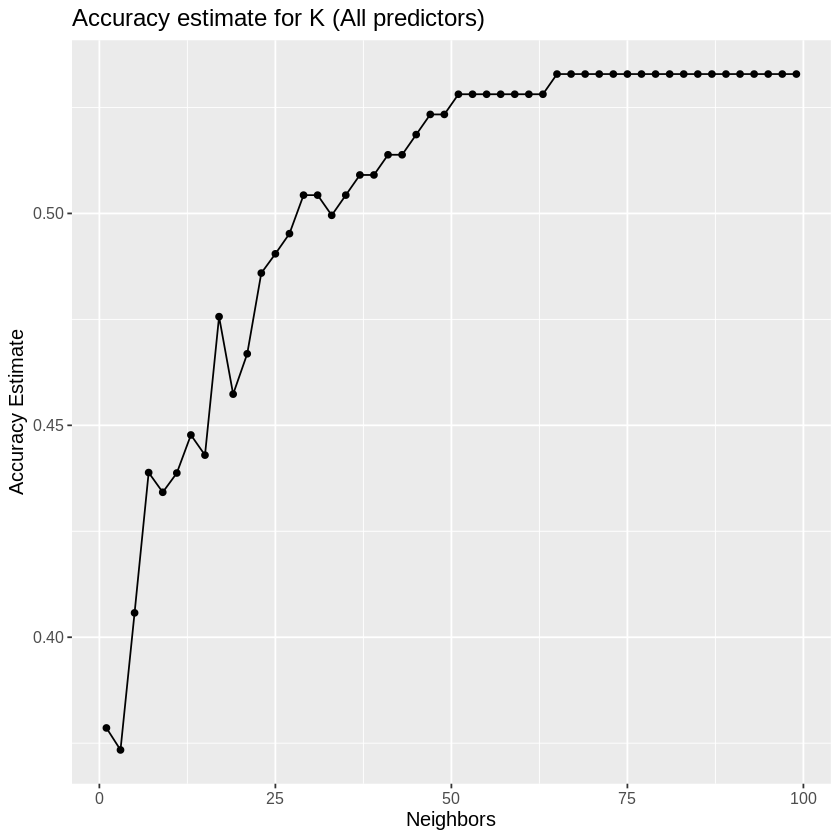

In [50]:
heart_recipe_all <- recipe(num ~ chol + age + restbps, data = patients_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 

knn_results_all <- workflow() %>%
  add_recipe(heart_recipe_all) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = heart_vfold, grid = k_vals) %>%
  collect_metrics()

accuracies_all <- knn_results_all %>%
    filter(.metric == "accuracy")

accuracy_vs_k_all <- ggplot(accuracies_all, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  ggtitle("Accuracy estimate for K (All predictors)") + 
  theme(text = element_text(size = 12))

accuracy_vs_k_all


From this plot, choose the best value of K and build the final classifer model using this chosen value of K 

In [12]:
chosen_n_all <- arrange(accuracies_all, by = desc(mean)) %>%
            slice(1) %>% 
            pull(neighbors)

knn_spec_all <- nearest_neighbor(weight_func = "rectangular", neighbors = chosen_n_all) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit_all <- workflow() %>%
                add_recipe(heart_recipe_all) %>%
                add_model(knn_spec_all) %>%
                fit(data = patients_train)

Now we want to assess the accuracy of our model

In [13]:
patients_test_predictions_all<- predict(knn_fit_all, patients_test) %>%
                             bind_cols(patients_test)

patients_test_predictions_accuracy_all <- metrics(patients_test_predictions_all, truth = num, estimate = .pred_class) %>%
                             filter(.metric == "accuracy")

patients_test_predictions_accuracy_all



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5617978


#### Repeat this process for the rest of the scenarios

#### _Scenario 2: Using only cholestoral and age as predictor variables_

! Fold2: internal: No observations were detected in `truth` for level(s): '4'
Com...



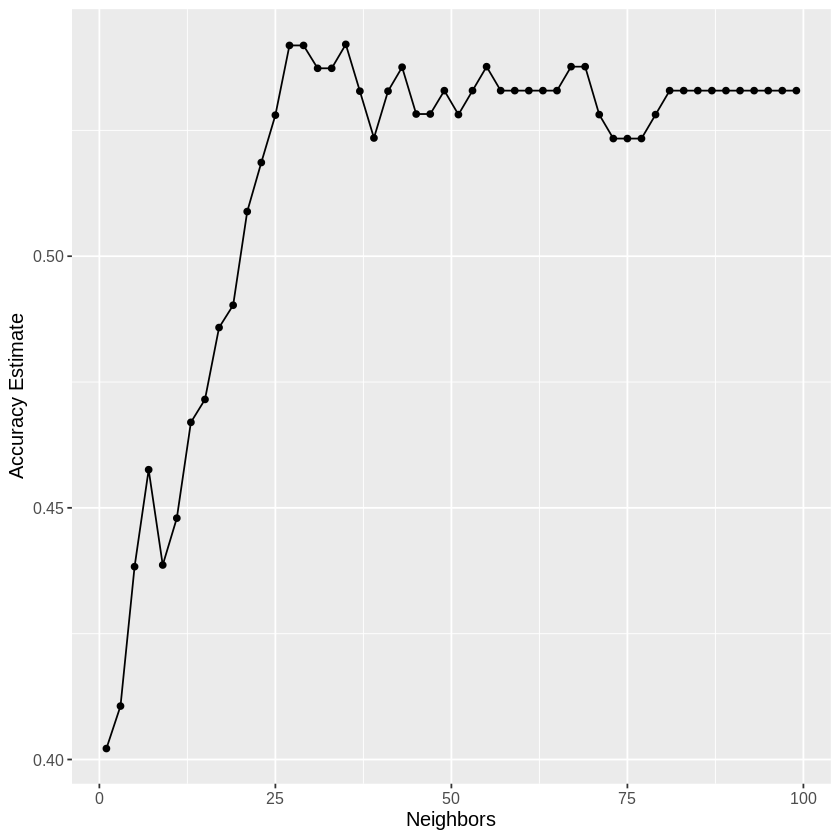

In [15]:
heart_recipe_chol_age <- recipe(num ~ chol + age, data = patients_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 

knn_results_chol_age <- workflow() %>%
  add_recipe(heart_recipe_chol_age) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = heart_vfold, grid = k_vals) %>%
  collect_metrics()

accuracies_chol_age <- knn_results_chol_age %>%
    filter(.metric == "accuracy")

accuracy_vs_k_chol_age <- ggplot(accuracies_chol_age, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  ggtitle("Accuracy estimate for K (chol and age)") +
  theme(text = element_text(size = 12))

accuracy_vs_k_chol_age


In [16]:
chosen_n_chol_age <- arrange(accuracies_chol_age, by = desc(mean)) %>%
            slice(1) %>% 
            pull(neighbors)

knn_spec_chol_age <- nearest_neighbor(weight_func = "rectangular", neighbors = chosen_n_chol_age) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit_chol_age <- workflow() %>%
                add_recipe(heart_recipe_chol_age) %>%
                add_model(knn_spec_chol_age) %>%
                fit(data = patients_train)

patients_test_predictions_chol_age<- predict(knn_fit_chol_age, patients_test) %>%
                             bind_cols(patients_test)

patients_test_predictions_accuracy_chol_age <- metrics(patients_test_predictions_chol_age, truth = num, estimate = .pred_class) %>%
                             filter(.metric == "accuracy")

patients_test_predictions_accuracy_chol_age



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5730337


#### _Scenario 3: Using only cholestoral (chol) and resting blood pressure (bps) as predictor variables_

! Fold2: internal: No observations were detected in `truth` for level(s): '4'
Com...



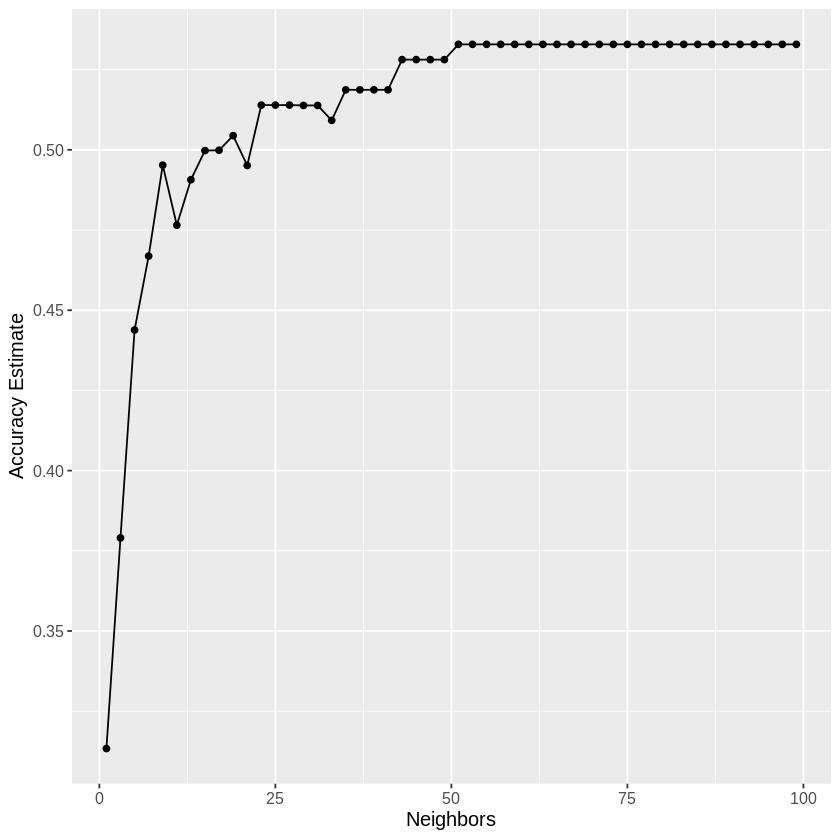

In [17]:
heart_recipe_chol_bps <- recipe(num ~ chol + restbps, data = patients_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 

knn_results_chol_bps <- workflow() %>%
  add_recipe(heart_recipe_chol_bps) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = heart_vfold, grid = k_vals) %>%
  collect_metrics()

accuracies_chol_bps <- knn_results_chol_bps %>%
    filter(.metric == "accuracy")

accuracy_vs_k_chol_bps <- ggplot(accuracies_chol_bps, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  ggtitle("Accuracy estimate for K (chol and resting blood pressure)") +
  theme(text = element_text(size = 12))

accuracy_vs_k_chol_bps


In [18]:
chosen_n_chol_bps <- arrange(accuracies_chol_bps, by = desc(mean)) %>%
            slice(1) %>% 
            pull(neighbors)

knn_spec_chol_bps <- nearest_neighbor(weight_func = "rectangular", neighbors = chosen_n_chol_bps) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit_chol_bps <- workflow() %>%
                add_recipe(heart_recipe_chol_bps) %>%
                add_model(knn_spec_chol_bps) %>%
                fit(data = patients_train)

patients_test_predictions_chol_bps<- predict(knn_fit_chol_bps, patients_test) %>%
                             bind_cols(patients_test)

patients_test_predictions_accuracy_chol_bps <- metrics(patients_test_predictions_chol_bps, truth = num, estimate = .pred_class) %>%
                             filter(.metric == "accuracy")

patients_test_predictions_accuracy_chol_bps



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5617978


#### _Scenario 4: Using only age and resting blood pressure (bps) as predictor variables_

! Fold2: internal: No observations were detected in `truth` for level(s): '4'
Com...



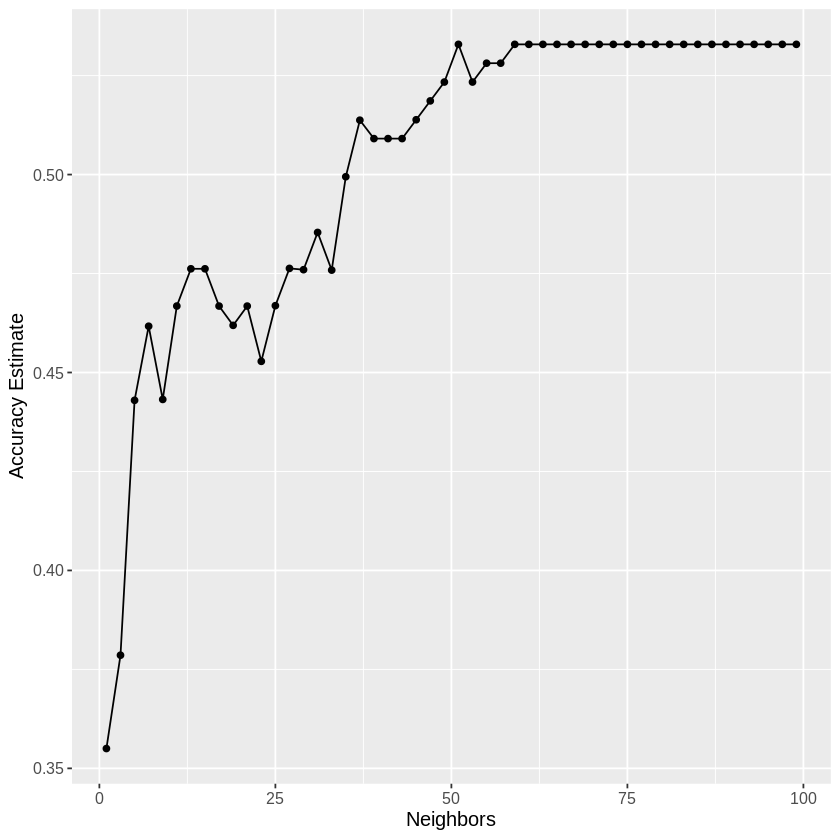

In [19]:
heart_recipe_age_bps <- recipe(num ~ age + restbps, data = patients_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 

knn_results_age_bps <- workflow() %>%
  add_recipe(heart_recipe_age_bps) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = heart_vfold, grid = k_vals) %>%
  collect_metrics()

accuracies_age_bps <- knn_results_age_bps %>%
    filter(.metric == "accuracy")

accuracy_vs_k_age_bps <- ggplot(accuracies_age_bps, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  ggtitle("Accuracy estimate for K (age and resting blood pressure)") +
  theme(text = element_text(size = 12))

accuracy_vs_k_age_bps


In [20]:
chosen_n_age_bps <- arrange(accuracies_age_bps, by = desc(mean)) %>%
            slice(1) %>% 
            pull(neighbors)

knn_spec_age_bps <- nearest_neighbor(weight_func = "rectangular", neighbors = chosen_n_age_bps) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit_age_bps <- workflow() %>%
                add_recipe(heart_recipe_age_bps) %>%
                add_model(knn_spec_age_bps) %>%
                fit(data = patients_train)

patients_test_predictions_age_bps<- predict(knn_fit_age_bps, patients_test) %>%
                             bind_cols(patients_test)

patients_test_predictions_accuracy_age_bps <- metrics(patients_test_predictions_age_bps, truth = num, estimate = .pred_class) %>%
                             filter(.metric == "accuracy")

patients_test_predictions_accuracy_age_bps



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5617978


Now that we have run all 4 versions, we are now able to choose the best subset of predictors. For easier comparison, we have summarised the accuracies of all 4 models below 

In [23]:
patients_test_predictions_accuracy_all

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5617978


In [24]:
patients_test_predictions_accuracy_chol_age

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5730337


In [27]:
patients_test_predictions_accuracy_chol_bps

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5617978


In [28]:
patients_test_predictions_accuracy_age_bps

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5617978


From this, we can see that using only 2 predictor variables, cholestero (chol) and age will give us the highest accuracy. As such, we will use these chol and age to build our final classifer. 

## Building the final classifer model 

From our pre-processing, we have determined that using **chol and age** as our predictor variables, and a **k value of 35** will give us the most accurate prediction. We will therefore incorporate these into a workflow to build our final K-nearest neighbours classifer. We are able to reuse the recipe (heart_recipe_chol_age) here. 

In [47]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 35) %>%
    set_engine("kknn") %>% 
    set_mode("classification") 

knn_fit <- workflow() %>%
    add_recipe(heart_recipe_chol_age) %>% 
    add_model(knn_spec) %>%
    fit(data = patients_train)

knn_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~35, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4626168
Best kernel: rectangular
Best k: 35

## Predicting new observations

We can now use our model to predict new observations, we've made a dummy observation showcasing a 50 year old individual with an average level of serum cholesterol level of 170 mg/dl here just as an example. 

In [53]:
new_observation <- tibble(age = 50, chol = 170)
prediction <- predict(knn_fit, new_observation)

prediction

.pred_class
<fct>
0


As the predicted class was 0, the dummy individual was predicted to have no heart disease. 

## Summary of Methods:

* This K-nearest neighbour classifier was built in an effort to find the relationship between the chosen three predictor variables and the severity of heart disease to discover which variable(s) could predict heart disease severity most accurately.

* In training the classifier, cross-validation and tuning was utilised to find the best unbiased parameter value of K, as that determines the accuracy of our classifer.  5 folds was chosen for crossvalidation as it was the best tradeoff between standard error and computation processing speed. 10 folds did not decrease the standard error by a significant amount, but it did cause the processing speed to increases substantially. 


#### Summarised step-by-step process of building the classifier

1. Loaded the necessary libraries into R 
2. Loaded the cleveland data set into R
3. Selected for age, restbps and chol and converted the **num** numerical variable into a factor, as it is the class label 
4. Explored the data set using scatterplot visualisations to understand the dataset. 
5. Split the cleveland data into a training and test set into a 70:30 ratio, using num to stratify as heart disease severity is what we want to predict. 
5. Trained 4 versions of a classifer model using different subsets of predictors to find the best subset. 
6. Ran all 4 models and assess their accuracy against the testing data
7. Ploted accuracy against K to find the number of neighbours that will give the highest accuracy 
8. Chose the model with the highest accuracy, thereby determining the value of K and the predictor subset for the final classifer model 
6. Built the final classifer model 


# Discussion

## Expected Outcomes and Significance
Increasing age and risk of contracting heart disease has consistently shown to be positively correlated (Roth et al. 2985) and the average lifestyle men lead incorporates more high-risk factors for heart disease compared to women. (Dai et al. 6) Older men are therefore more likely to contract cardiovascular diseases, and we expected to see this reflected in our results.
 
Ultimately, we aimed to create a classification model that can contribute to the ongoing effort to help healthcare workers efficiently target individuals at risk of developing heart disease or quickly identify the severity of the disease for patients. 


## Actual Outcomes

xx

Age and serum cholestoral were found to be the best predictor subsets, and the reason for this can explore this with greater nuance if we follow Marateb and Goudarzi's method (216) to straify the age into age groups, as specified below, and explore the distribution of minimum and maximum serum cholestoral in mg/dlin each age group. Achieve this by running the cell below. 

**Age groups:**
* Young adult (18-35 years old)
* Middle adult(36-55 years old)
* Old adult (>55 years old)


In [60]:
young_adult_chol <- cleveland_df_sel %>%
select(age,chol) %>%
filter(between(age,18, 35))
max_young_chol <- young_adult_chol %>% 
    arrange(desc(chol))%>% 
    head(n=1)
min_young_chol <- young_adult_chol %>% 
    arrange(desc(chol)) %>%
    tail(n=1)

middle_adult_chol <- cleveland_df_sel %>%
select(age,chol) %>%
filter(between(age,36, 55))
max_middle_chol <- middle_adult_chol %>% 
    arrange(desc(chol)) %>%
    head(n=1)
min_middle_chol <- middle_adult_chol %>% 
    arrange(desc(chol)) %>%
    tail(n=1)

old_adult_chol <- cleveland_df_sel %>%
select(age, chol) %>%
filter(between(age,55,77))
max_old_chol <- old_adult_chol %>% 
    arrange(desc(chol)) %>%
    head(n=1)
min_old_chol <- old_adult_chol %>% 
    arrange(desc(chol)) %>%
    tail(n=1)

max_young_chol
min_young_chol

max_middle_chol
min_middle_chol

max_old_chol
min_old_chol


age,chol
<dbl>,<dbl>
35,282


age,chol
<dbl>,<dbl>
34,182


age,chol
<dbl>,<dbl>
55,353


age,chol
<dbl>,<dbl>
44,141


age,chol
<dbl>,<dbl>
67,564


age,chol
<dbl>,<dbl>
57,126


From this we can see that 

## Limitations and further questions

(Talk about low accuracy)

The dataset used to train our model used data collected from May 1981 to 1984 (Detrano et al. 305), and the age of the data was assumed negligible. Therefore, it would be interesting to repeat the project with more recent data to compare for any differences in observations. Furthermore, the proportion of low-income individuals in the test group is unknown. Considering the goal of our project, it would be worth exploring if focusing more explicitly on low-income individuals using the same model would produce different results

## Bibliography 

Bowry, A. D. K., Lewey, J., Dugani, S. B., & Choudhry, N. K. (2015). The Burden of Cardiovascular Disease in Low- and Middle-Income Countries: Epidemiology and Management. Canadian Journal of Cardiology, 31(9), 1151–1159. https://doi.org/10.1016/j.cjca.2015.06.028

Dai, H., Tang, B., Younis, A., Kong, J. D., Zhong, W., & Bragazzi, N. L. (2021). Regional and socioeconomic disparities in cardiovascular disease in Canada during 2005–2016: Evidence from repeated nationwide cross-sectional surveys. BMJ Global Health, 6(11), e006809. https://doi.org/10.1136/bmjgh-2021-006809

Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J.-J., Sandhu, S., Guppy, K. H., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. The American Journal of Cardiology, 64(5), 304–310. https://doi.org/10.1016/0002-9149(89)90524-9

Libby, P., & Theroux, P. (2005). Pathophysiology of Coronary Artery Disease. Circulation, 111(25), 3481–3488. https://doi.org/10.1161/CIRCULATIONAHA.105.537878

Mannien, V., Tenkanen, L., & Koskinen, P. (1992). Joint Effects of Serum Triglyceride and LDL Cholesterol and HDL Cholesterol Concentrations on Coronary Heart Disease Risk in the Helsinki Heart Study. The Endocrinologist, 2(3), 209. https://doi.org/10.1097/00019616-199205000-00025 

UCI Machine Learning Repository: Heart Disease Data Set. (n.d.). Retrieved 3 March 2022, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Roth, G. A., Mensah, G. A., Johnson, C. O., Addolorato, G., Ammirati, E., Baddour, L. M., Barengo, N. C., Beaton, A. Z., Benjamin, E. J., Benziger, C. P., Bonny, A., Brauer, M., Brodmann, M., Cahill, T. J., Carapetis, J., Catapano, A. L., Chugh, S. S., Cooper, L. T., Coresh, J., … Fuster, V. (2020). Global Burden of Cardiovascular Diseases and Risk Factors, 1990–2019. Journal of the American College of Cardiology, 76(25), 2982–3021. https://doi.org/10.1016/j.jacc.2020.11.010

Marateb, H. R., & Goudarzi, S. (2015). A noninvasive method for coronary artery diseases diagnosis using a clinically-interpretable fuzzy rule-based system. Journal of Research in Medical Sciences : The Official Journal of Isfahan University of Medical Sciences, 20(3), 214–223.

Nahar, J., Imam, T., Tickle, K. S., & Chen, Y.-P. P. (2013). Association rule mining to detect factors which contribute to heart disease in males and females. Expert Systems with Applications, 40(4), 1086–1093. https://doi.org/10.1016/j.eswa.2012.08.028


